# Importing of Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from turtle import color

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.feature_selection import RFE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix,mean_squared_error)

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import optuna

# !pip install --quiet shap==0.39.0
import shap

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# The Data

In [2]:
df=pd.read_csv('WildBlueberryPollinationSimulationData.csv')

In [3]:
df.head()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [4]:
df.shape

(777, 18)

In [5]:
df.columns

Index(['Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [6]:
df.drop('Row#',axis=1,inplace=True)

In [7]:
df.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [8]:
df.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,18.767696,0.417133,0.282389,0.468817,0.562062,82.277091,49.700515,68.723037,59.309395,28.690219,48.613127,18.309292,0.320000,0.502121,0.445983,36.122432,6012.849165
std,6.999063,0.978904,0.066343,0.161052,0.169119,9.193745,5.595769,7.676984,6.647760,3.209547,5.417072,12.124226,0.171279,0.079445,0.040333,4.377889,1356.955318
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1637.704022
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,3.770000,0.100000,0.454725,0.416281,33.116091,5124.854901
50%,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.508297,0.445587,36.166044,6107.382466
75%,25.000000,0.500000,0.380000,0.630000,0.750000,89.000000,52.000000,71.900000,66.000000,30.000000,50.800000,24.000000,0.390000,0.561297,0.476149,39.239668,7022.189731
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401842


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             777 non-null    float64
 1   honeybee              777 non-null    float64
 2   bumbles               777 non-null    float64
 3   andrena               777 non-null    float64
 4   osmia                 777 non-null    float64
 5   MaxOfUpperTRange      777 non-null    float64
 6   MinOfUpperTRange      777 non-null    float64
 7   AverageOfUpperTRange  777 non-null    float64
 8   MaxOfLowerTRange      777 non-null    float64
 9   MinOfLowerTRange      777 non-null    float64
 10  AverageOfLowerTRange  777 non-null    float64
 11  RainingDays           777 non-null    float64
 12  AverageRainingDays    777 non-null    float64
 13  fruitset              777 non-null    float64
 14  fruitmass             777 non-null    float64
 15  seeds                 7

# Exploratory Data Analysis

In [10]:
df.isna().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

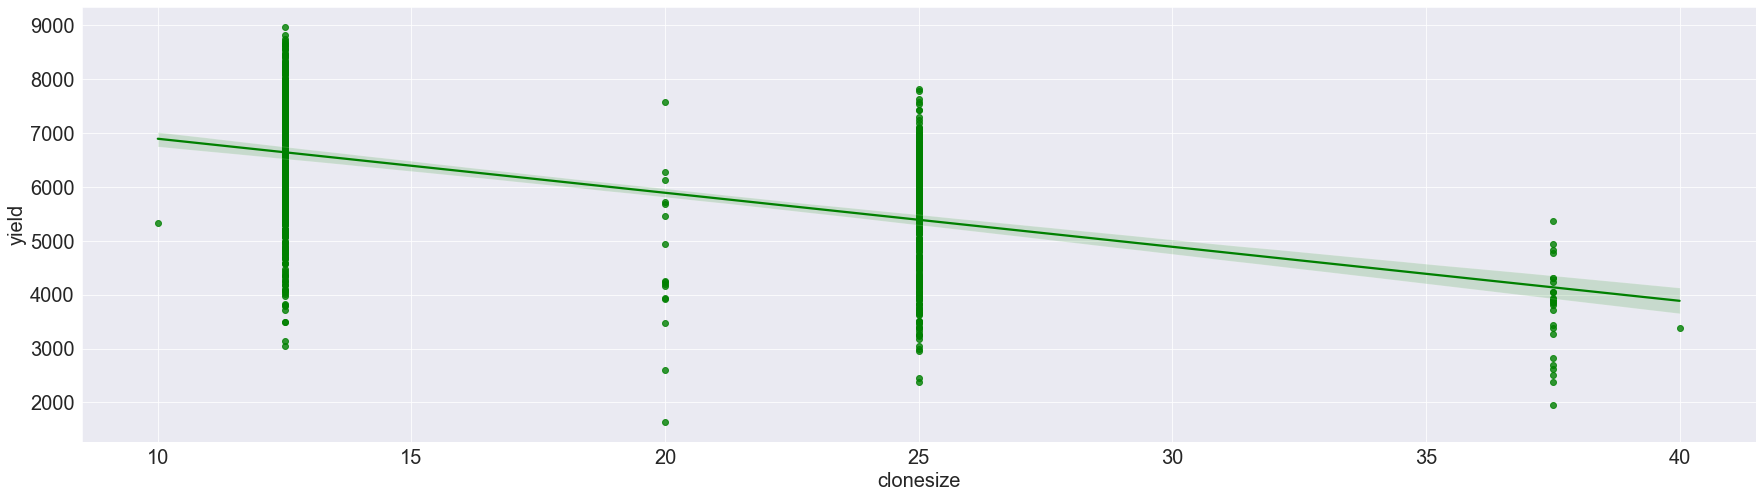

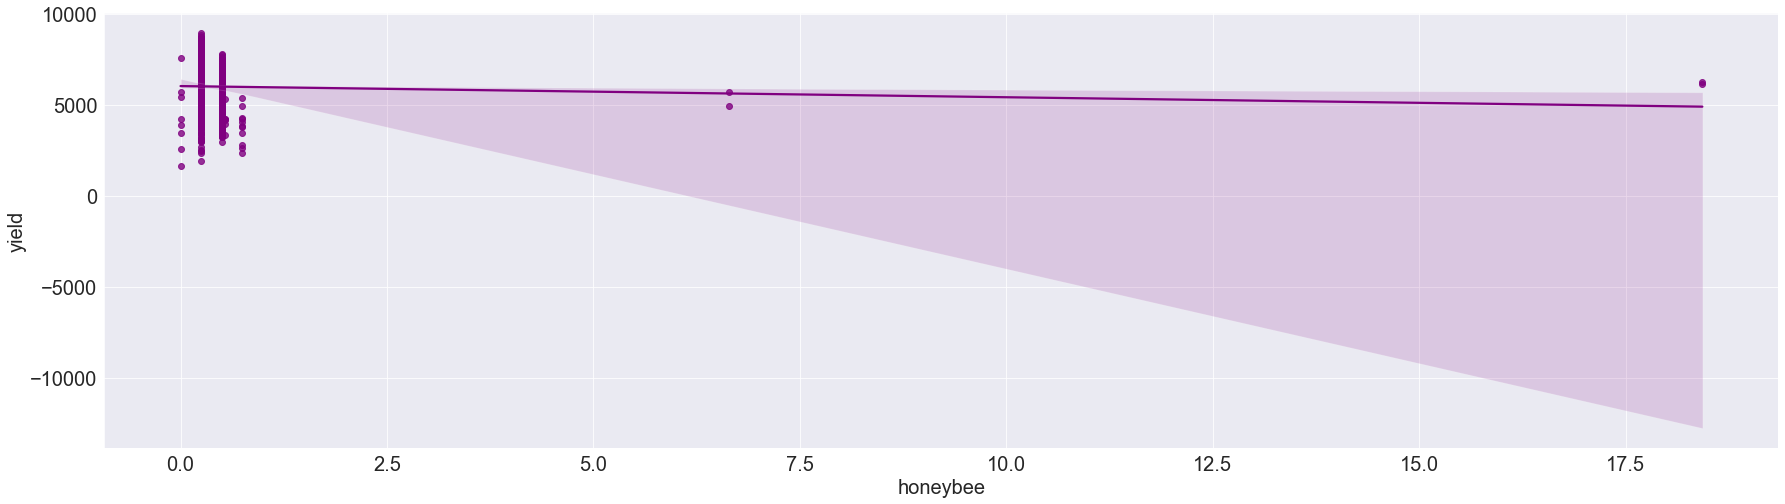

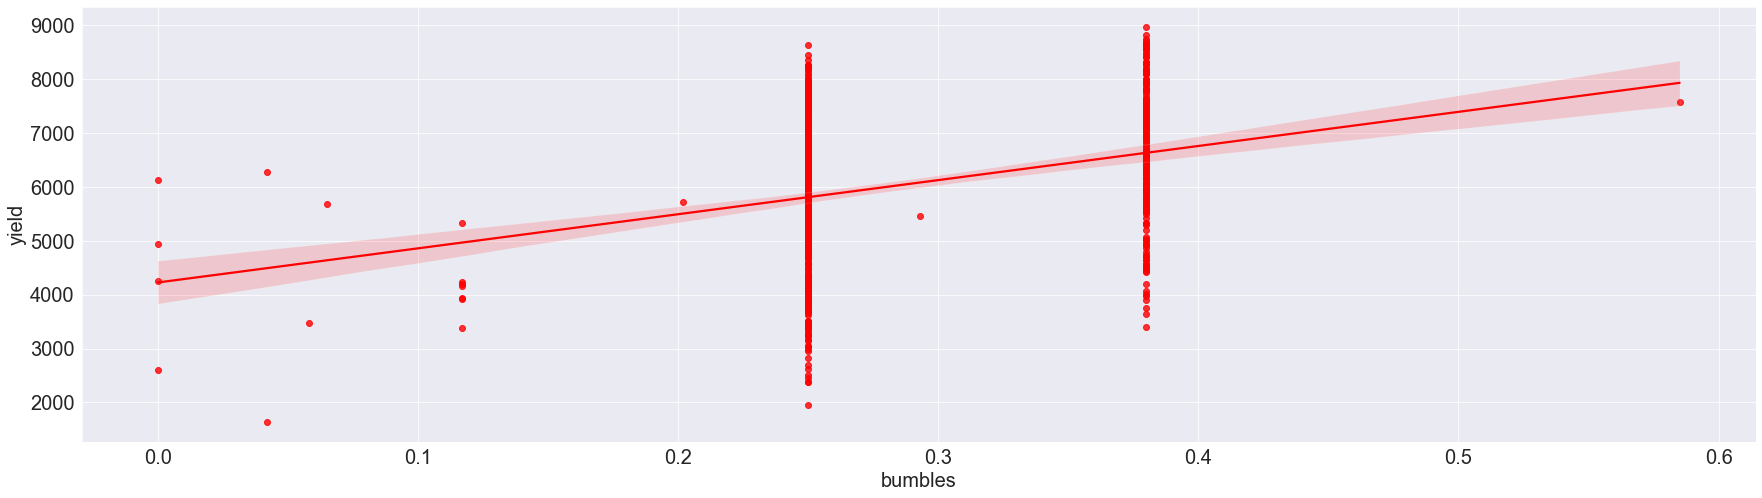

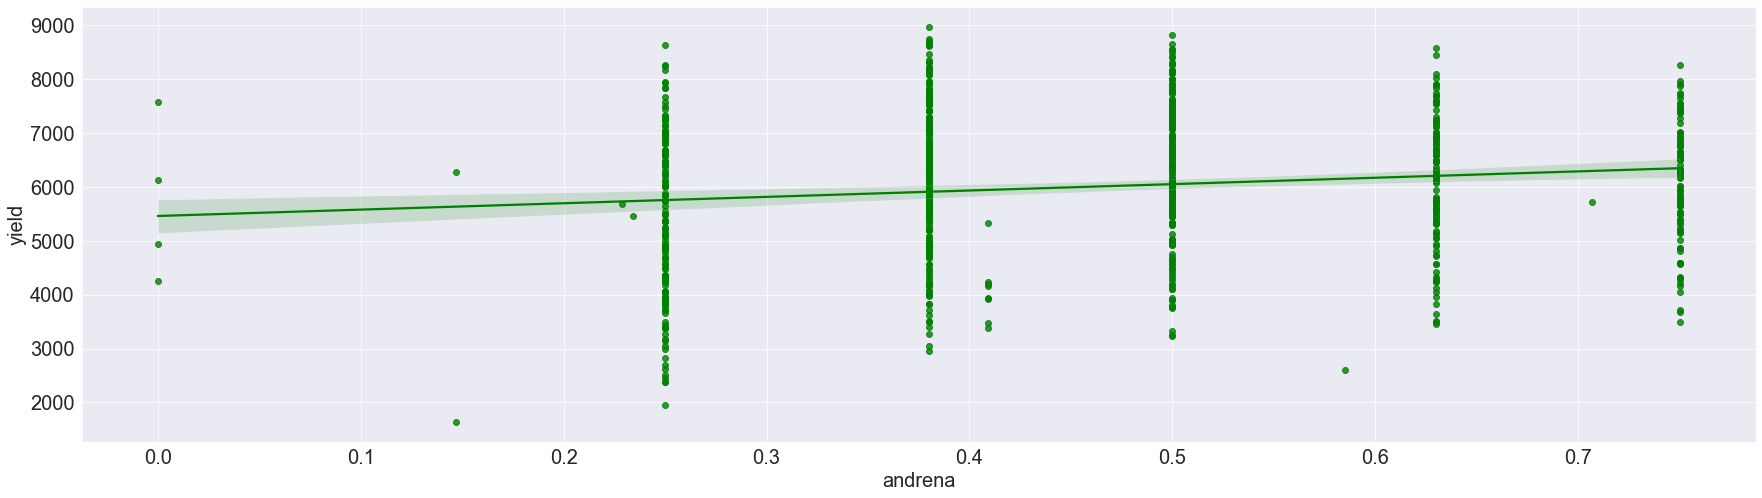

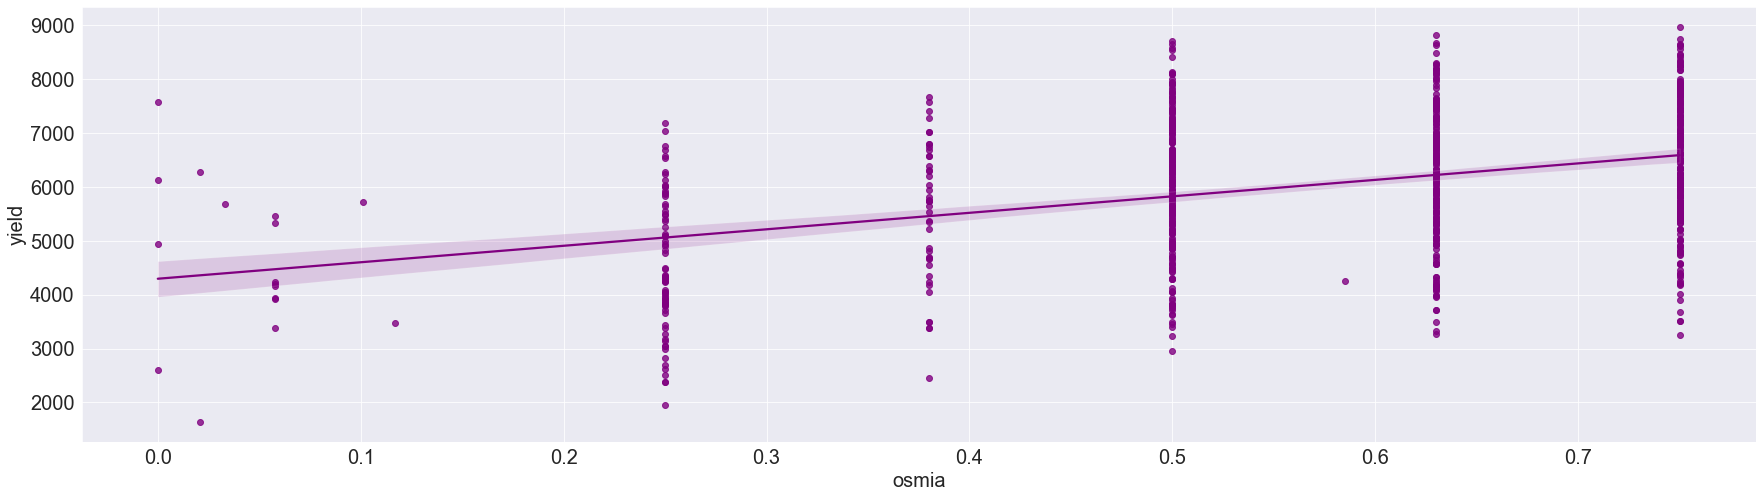

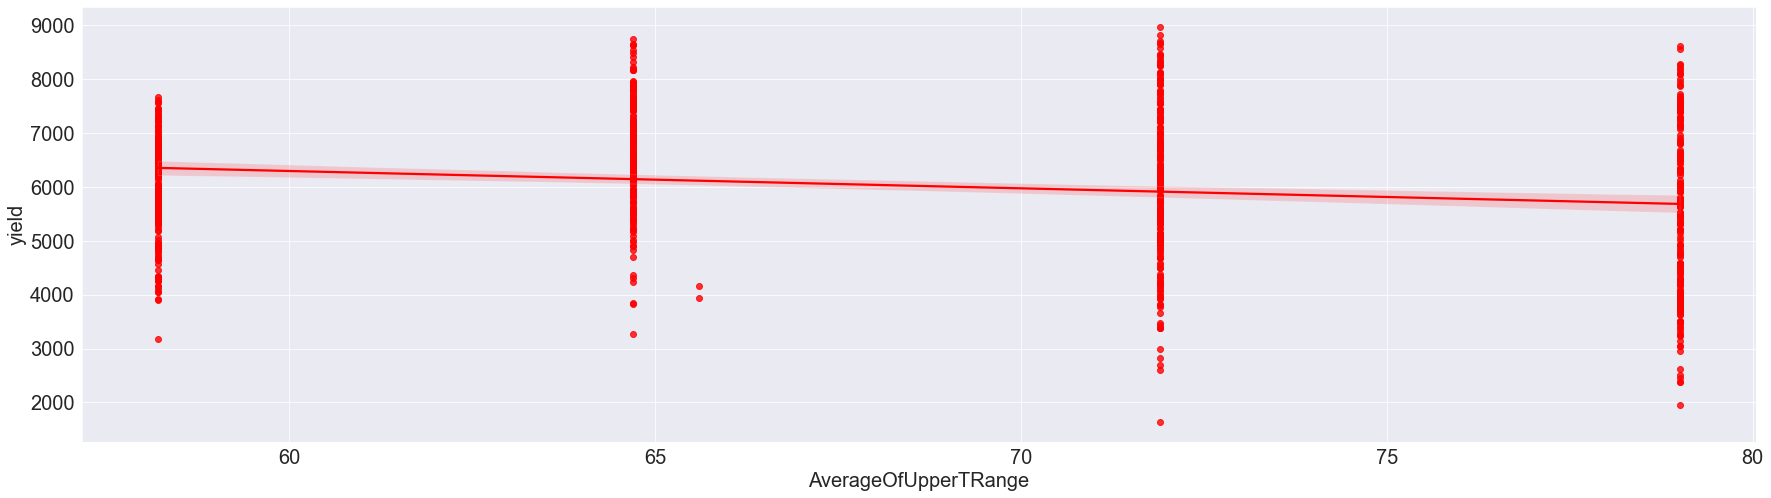

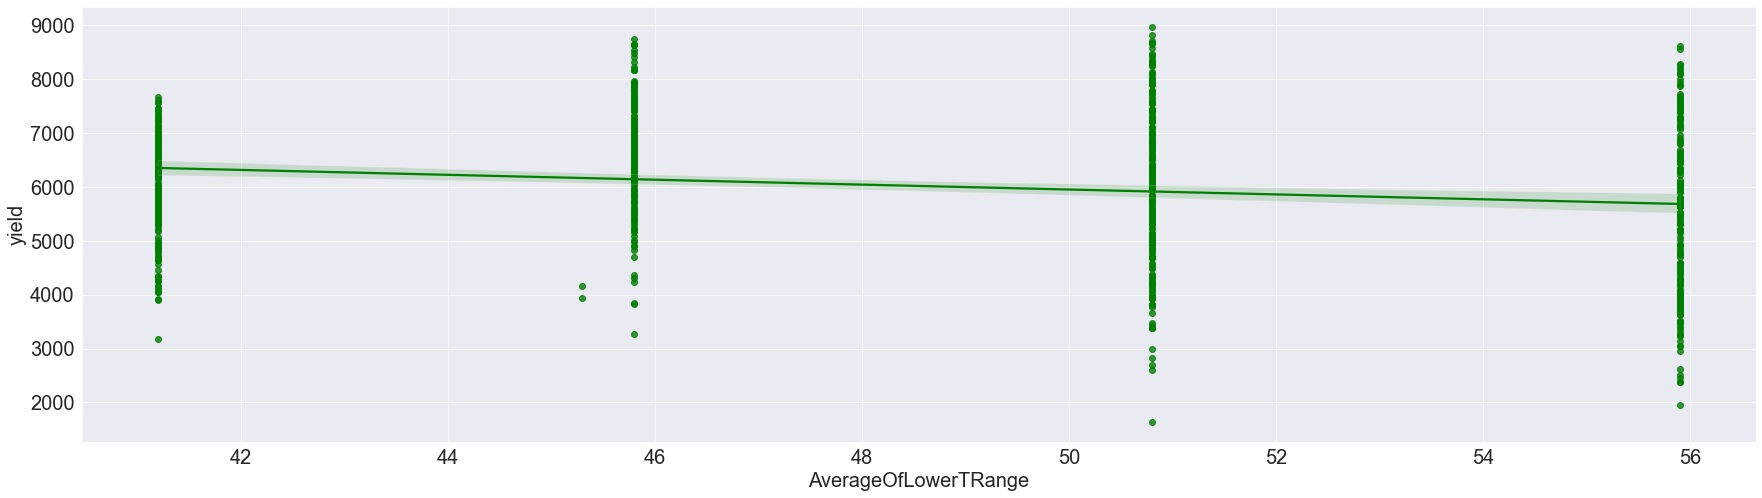

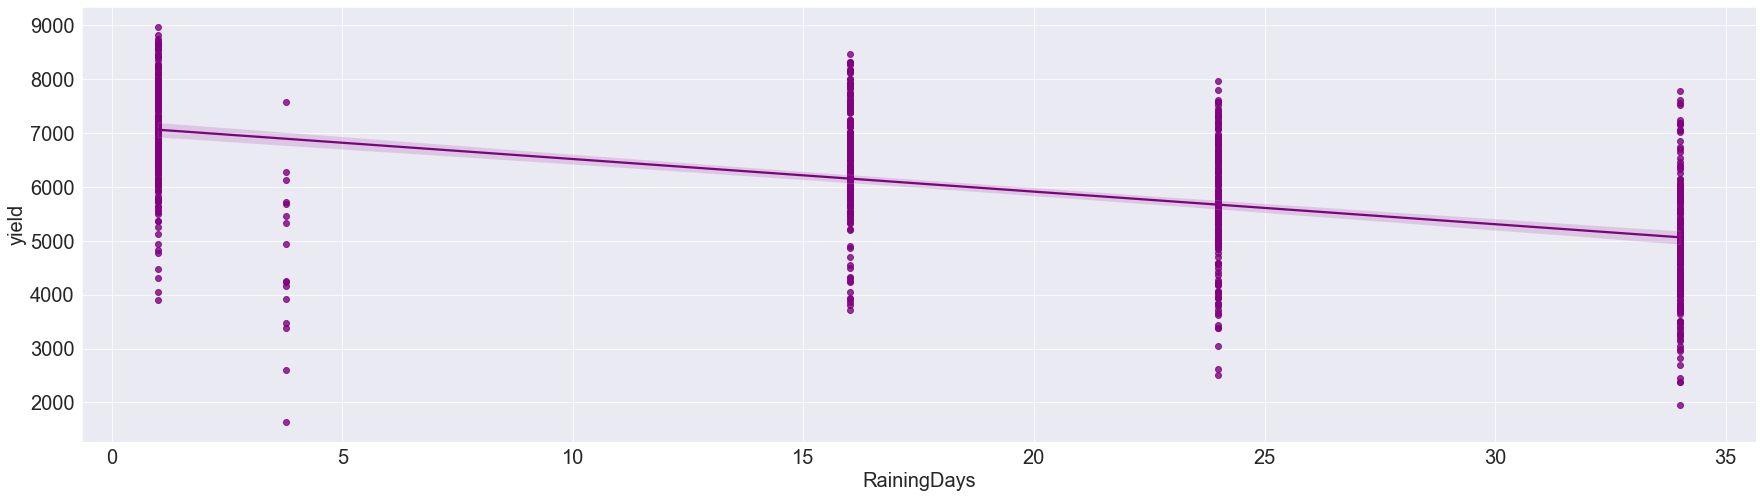

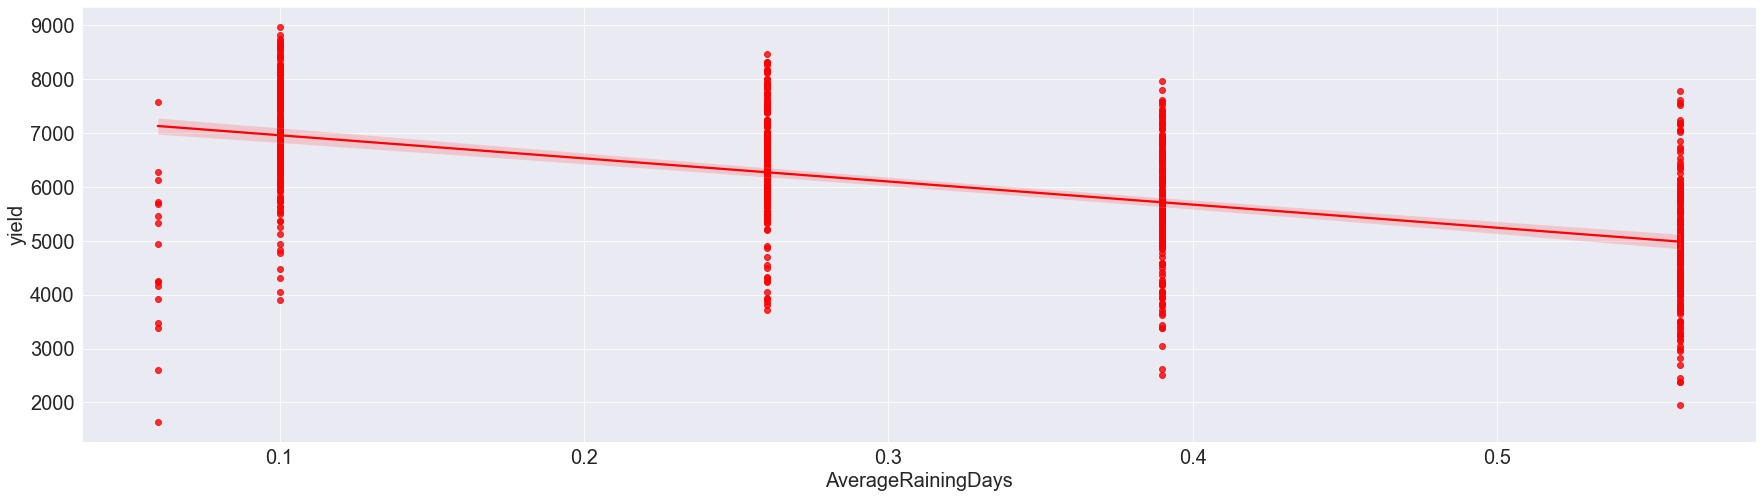

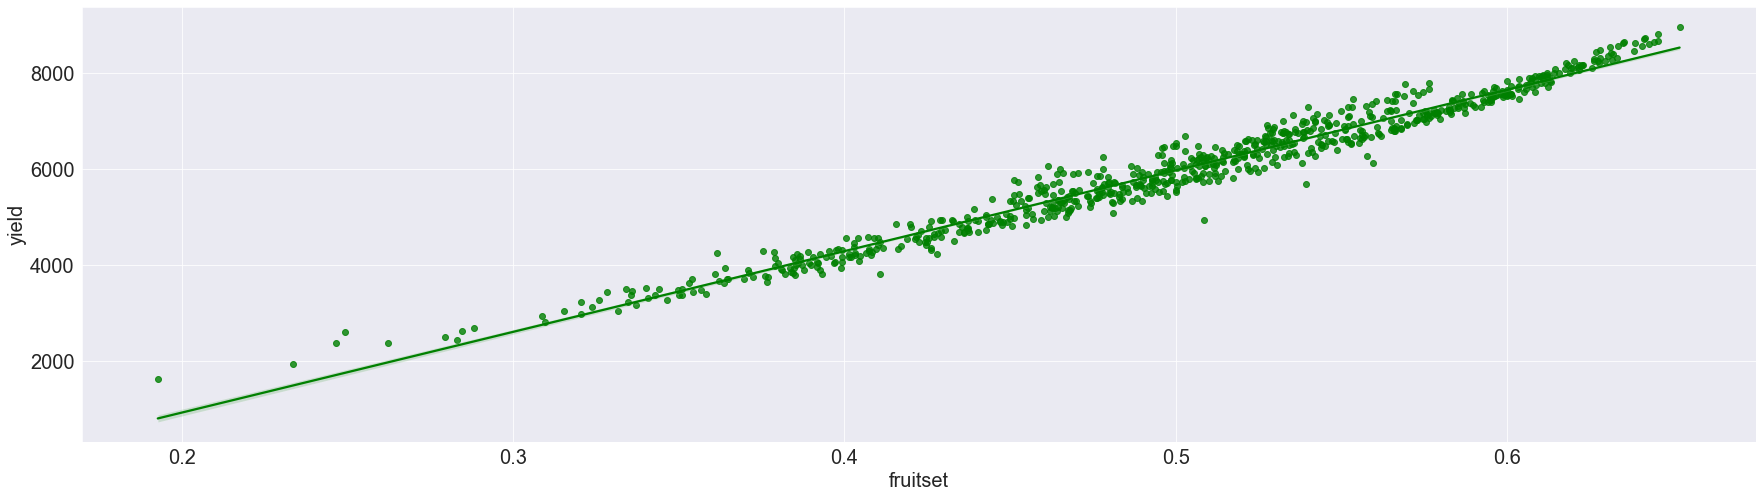

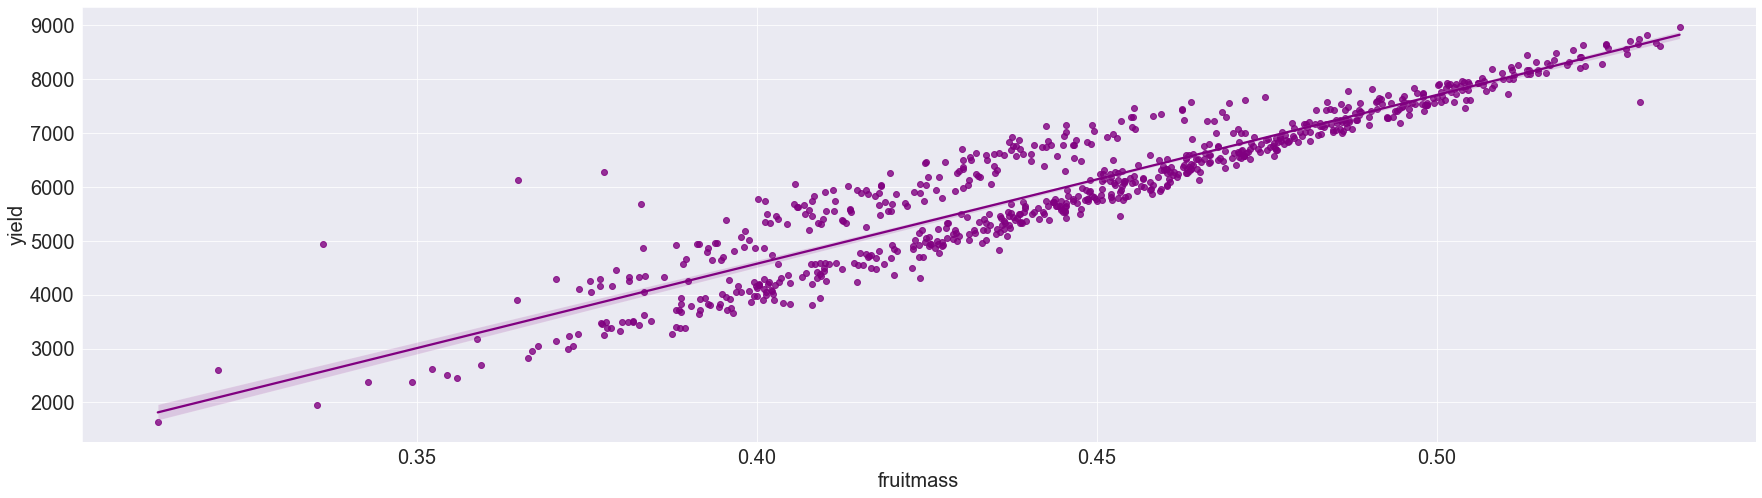

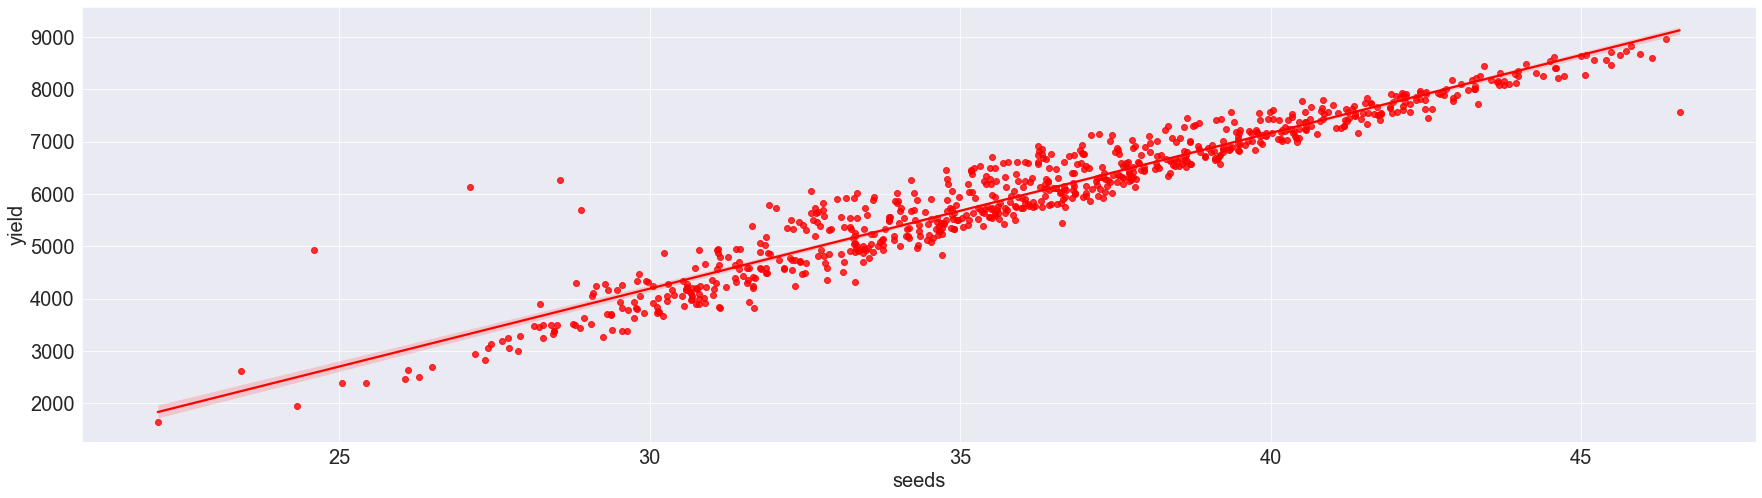

In [11]:
cols=['clonesize','honeybee','bumbles','andrena','osmia','AverageOfUpperTRange','AverageOfLowerTRange','RainingDays','AverageRainingDays',
'fruitset','fruitmass','seeds']
colors=['red','green','purple']
plot=1
for i in cols:
    plt.figure(figsize=(30,8))
    sns.regplot(x=df[i],y=df['yield'],color=colors[plot%3],ci=95)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(fontsize=20,xlabel=i)
    plt.ylabel(fontsize=20,ylabel='yield')
    plot+=1

<AxesSubplot:>

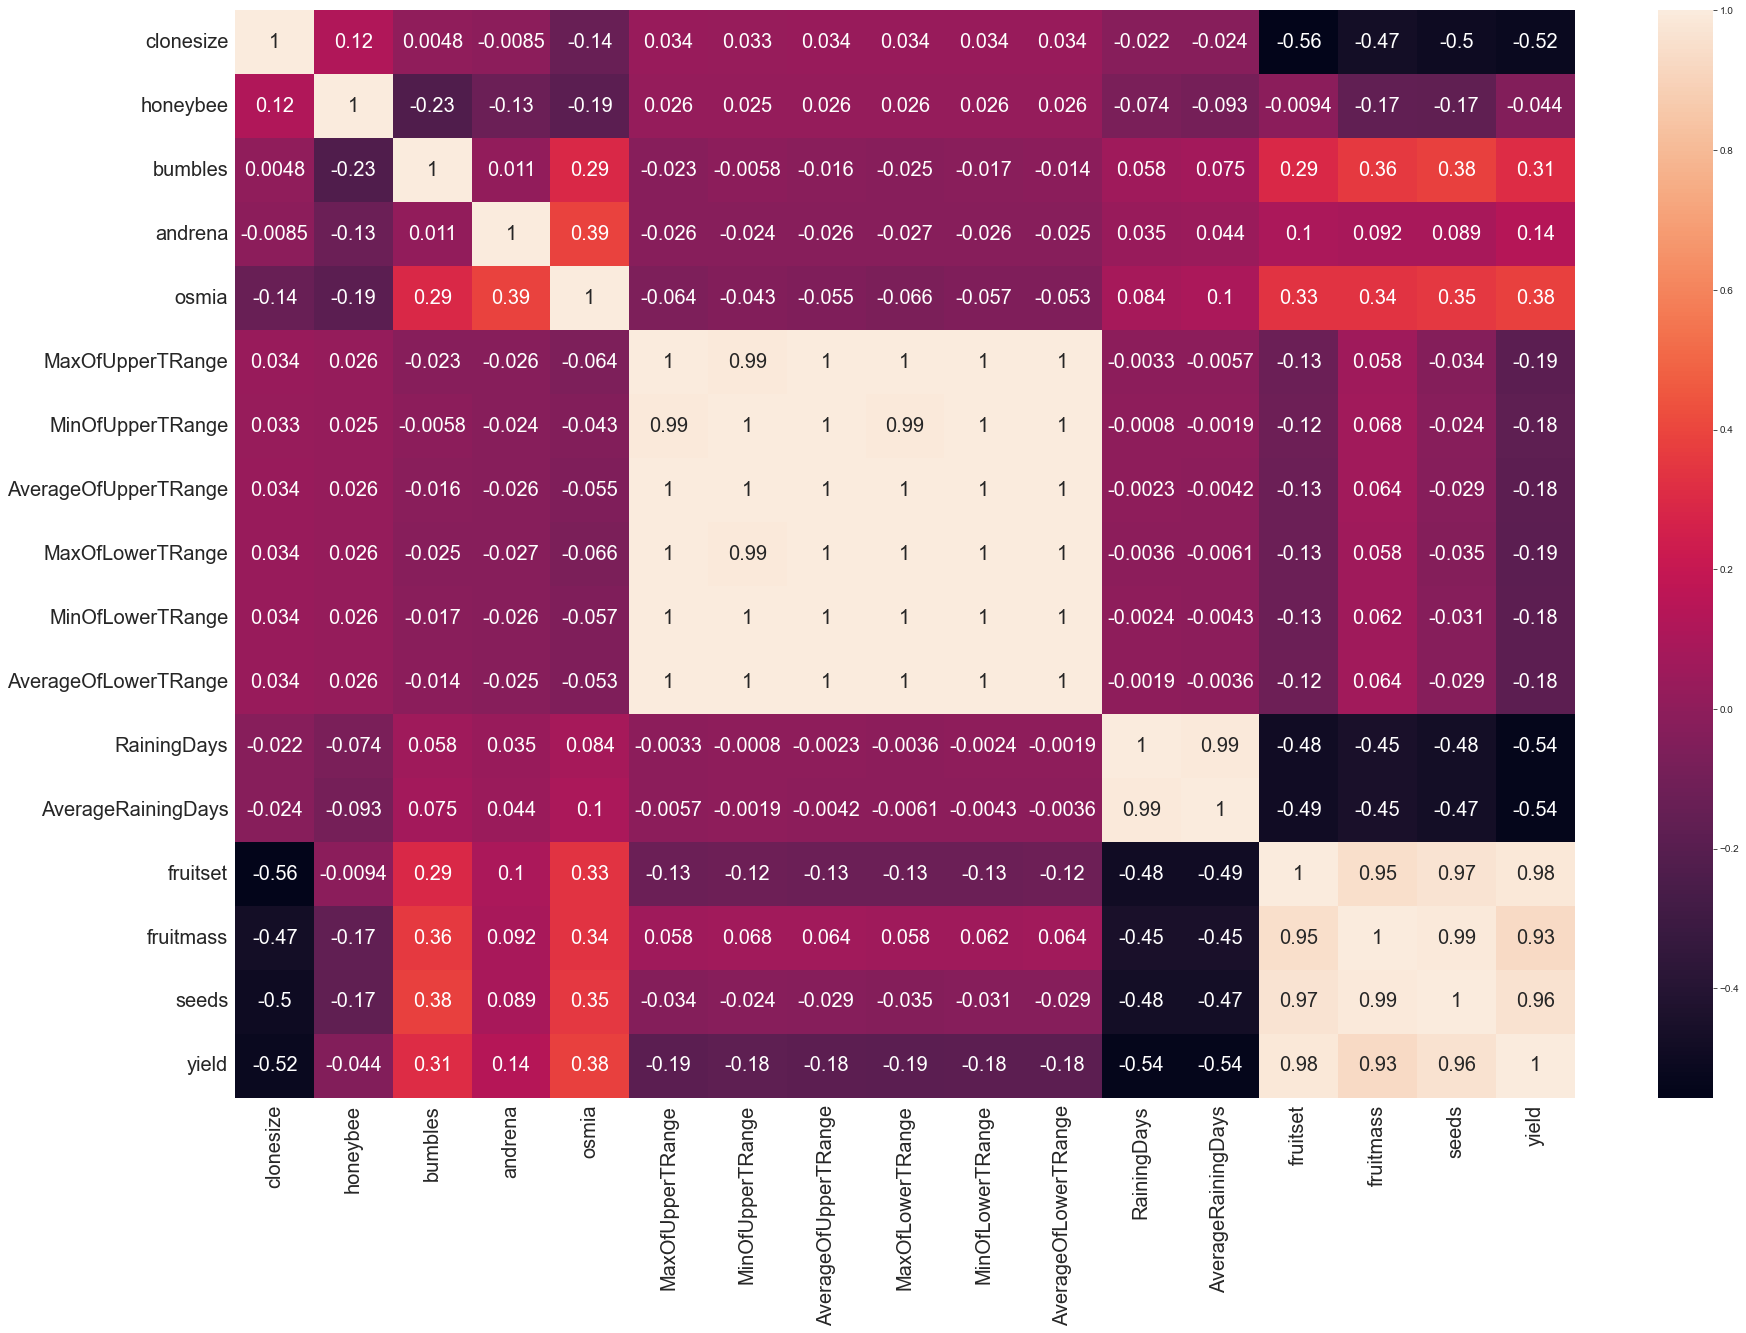

In [12]:
plt.figure(figsize=(30,20))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(df.corr(),annot=True,annot_kws={'size':20})

### Observations

- There are no missing values, so there is no need for imputation.
- The fields related to temperature ranges are extremely correlated, so we introduce an Average Temperature column to tackle the multicollinearity.
- The fields related to the fruit composition are also extremely correlated, so we take the fruitset column to include the fruitmass and seeds in one column, thus tackling multicollinearity here.

# Preprocessing

### Introduction of new Features

In [13]:
df['AvgTemp']=(df['AverageOfLowerTRange']+df['AverageOfUpperTRange'])/2

In [17]:
df.drop('AvgTemp',axis=1,inplace=True)

### Feature Selection

In [21]:
x=pd.DataFrame()
c=['clonesize','honeybee','bumbles','andrena','osmia','MaxOfUpperTRange','RainingDays','yield']
for i in c:
    x[i]=df[i]
y=x.pop('yield')

# Train Test Split

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=42)

# Model Building

In [23]:
xgb=XGBRegressor()
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_test)
print("RMSE:",mean_squared_error(y_pred,y_test,squared=False))

RMSE: 320.5242815681767


In [24]:
print("RMSE %:",mean_squared_error(y_pred,y_test,squared=False)*100/df['yield'].mean(),"%")

RMSE %: 5.33065561417155 %


In [25]:
joblib.dump(xgb,'blueberry.sav')

['blueberry.sav']